In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import os
import re
import copy
import operator
from sklearn.decomposition import PCA
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
os.getcwd()

'/home/ubuntu/02-710/datasets/hemberg_human_pancreas'

In [3]:
path1 = os.path.join(os.getcwd(), '1/')
path2 = os.path.join(os.getcwd(), '2/')

## Helper Functions

In [4]:
def logify(mat):
    log_mat = mat + 1.0
    return log_mat.apply(np.log2)

In [5]:
def get_PCA_components(n_comp, arr):
    pca = PCA(n_components=n_comp)
    pca.fit(arr)
    pcomps = pca.fit_transform(arr)
    return pcomps, pca.explained_variance_ratio_    

In [6]:
def plot_2D_phenotype(components, option, phenotypes, phenotype_dict, var_ratio, title):
    # option can be cell_type, disease_condition or dataset
    fig = plt.figure()
    matplotlib.rcParams.update({'font.size':12})
    plt.rcParams["figure.figsize"] = (10,10)
    legend_set =  sorted(phenotype_dict.items(), key=operator.itemgetter(1))
    if option == 'cell_type':
        colors = ['Red', 'Blue', 'Black', 'Yellow']
        pheno_label = 'cell_type'
    elif option == 'disease_type':
        colors = ['Red', 'Blue']
        pheno_label = 'disease_conditon'
    else:
        colors = ['Red', 'Blue']
        pheno_label = 'dataset'
        
    for k, col in zip(legend_set, colors):
        plot_idxs = np.where(phenotypes == k[1])
        plt.scatter(components[plot_idxs,0], components[plot_idxs, 1], c=col, alpha=0.5)
           
    plt.xlabel('Principal Component 1 (Variance = %s %%)' %(var_ratio[0] * 100))
    plt.ylabel('Principal Component 2 (Variance = %s %%)' %(var_ratio[1] * 100))
    plt.title(title)
    plt.legend([i[0] for i in legend_set])
    plt.show()

In [7]:
def plot_histogram(values, bins, title, xlabel, ylabel):
    plt.figure(figsize=(7,7))
    plt.hist(values, bins, histtype="bar", rwidth=0.8)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

## Datasets

In [8]:
mat1 = pd.read_pickle(os.path.join(path1, '2_mat1_with_pheno.pkl'))
mat2 = pd.read_pickle(os.path.join(path2, '2_mat2_with_pheno.pkl'))

In [9]:
print(mat1.shape)
print(mat2.shape)

(1467, 20966)
(1600, 20966)


In [10]:
# Adding dataset 'phenotype'
mat1['dataset'] = pd.Series(dtype=int, index=mat1.index, data=np.ones(mat1.shape[0]))
mat1.head(2)

#samples,TRIB1,LRRC49,MPPED2,DDX39A,MIR5092,HTR3C,KIAA1107,HAUS8,DIAPH3-AS1,MIR3935,...,RPS6KA4,PAFAH2,HHLA1,SLC35D3,ZBTB11-AS1,CCDC39,LOC100499484-C9ORF174,cell_type,disease_condition,dataset
HP1502401_H13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1
HP1502401_J14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,16.262977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [11]:
mat2['dataset'] = pd.Series(dtype=int, index=mat2.index, data=np.ones(mat2.shape[0]))
mat2['dataset'] *= 2
mat2.head(2)

gene_symbol,TRIB1,LRRC49,MPPED2,DDX39A,MIR5092,HTR3C,KIAA1107,HAUS8,DIAPH3-AS1,MIR3935,...,RPS6KA4,PAFAH2,HHLA1,SLC35D3,ZBTB11-AS1,CCDC39,LOC100499484-C9ORF174,cell_type,disease_condition,dataset
Sample_1,0.0,0.0000,0.0,0.0,0.0,0.0,0.0000,109.1049,0.0,0.0,...,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
Sample_2,0.0,40.7843,0.0,0.0,0.0,0.0,51.4727,0.0000,0.0,0.0,...,0.0,2.9446,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2


In [12]:
pheno1 = mat1[['cell_type', 'disease_condition', 'dataset']]
pheno2 = mat2[['cell_type', 'disease_condition', 'dataset']]

In [13]:
print(pheno1.shape)
print(pheno2.shape)

(1467, 3)
(1600, 3)


In [14]:
mat1.drop(['cell_type', 'disease_condition', 'dataset'], axis=1, inplace=True)
mat2.drop(['cell_type', 'disease_condition', 'dataset'], axis=1, inplace=True)

In [15]:
mat1 = mat1.astype(float)
mat2 = mat2.astype(float)

In [16]:
# Convert to log RPKM
mat1_log = logify(mat1)
mat2_log = logify(mat2)

In [17]:
# Merging
merged_mat = pd.concat([mat1, mat2])
merged_mat_log = pd.concat([mat1_log, mat2_log])
merged_pheno = pd.concat([pheno1, pheno2])
full_dataset = pd.concat([merged_mat_log, merged_pheno], axis=1)
full_dataset = full_dataset.sample(frac=1)
print(merged_mat.shape)
print(merged_mat_log.shape)
print(merged_pheno.shape)
print(full_dataset.shape)

(3067, 20964)
(3067, 20964)
(3067, 3)
(3067, 20967)


In [18]:
full_dataset.head(2)

,TRIB1,LRRC49,MPPED2,DDX39A,MIR5092,HTR3C,KIAA1107,HAUS8,DIAPH3-AS1,MIR3935,...,RPS6KA4,PAFAH2,HHLA1,SLC35D3,ZBTB11-AS1,CCDC39,LOC100499484-C9ORF174,cell_type,disease_condition,dataset
Sample_1329,0.000000,0.338795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.042469,0.0,0.0,0.0,0.0,2.350441,0.0,1.0,2
Sample_1339,5.805096,0.742006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.009060,0.0,1.0,2


In [19]:
full_dataset.to_pickle('gans_input_data/1_merged_unfiltered_logRPKM_dataset.pkl')

## PCA with untransformed RPKM on unfiltered dataset

In [20]:
dataset_dict = {'E-MTAB-5061 dataset': 1, 'GSE81608 dataset': 2}

In [21]:
princ_comp_unfiltered_pure_rpkm, var_ratio = get_PCA_components(n_comp=2, arr=merged_mat.values)

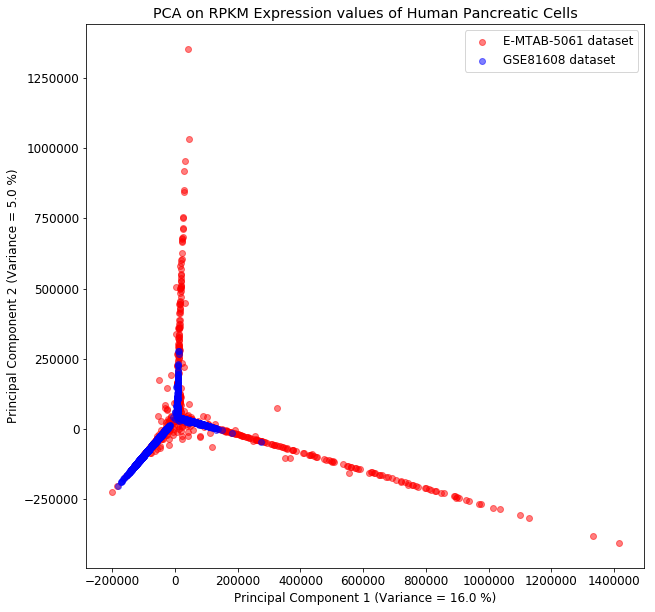

In [27]:
plot_2D_phenotype(components=princ_comp_unfiltered_pure_rpkm,
                   option='dataset',
                   phenotypes=merged_pheno['dataset'].values,
                   phenotype_dict=dataset_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on RPKM Expression values of Human Pancreatic Cells')

## PCA with log2 RPKM Transformation on unfiltered dataset:

In [23]:
princ_comp_unfiltered_log_rpkm, var_ratio = get_PCA_components(n_comp=2, arr=merged_mat_log.values)

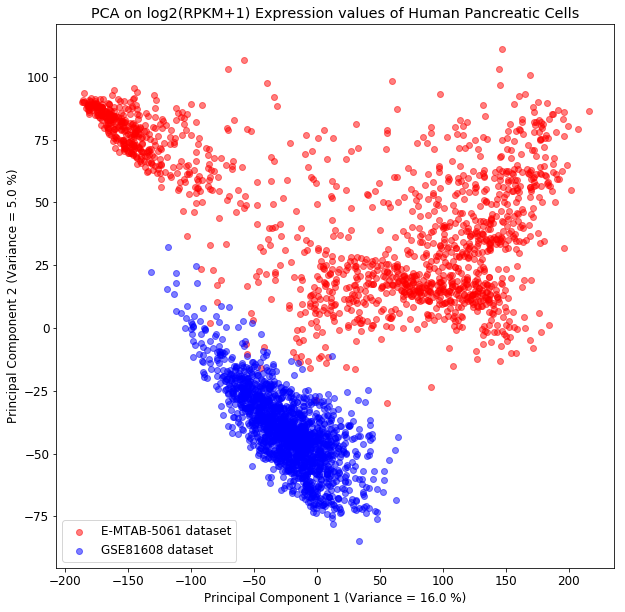

In [24]:
plot_2D_phenotype(components=princ_comp_unfiltered_log_rpkm,
                   option='dataset',
                   phenotypes=merged_pheno['dataset'].values,
                   phenotype_dict=dataset_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1) Expression values of Human Pancreatic Cells')

## PCA results, colored by cell type

In [28]:
cell_type_dict = {'alpha cell': 0, 
                    'beta cell': 1,
                    'delta cell': 2,
                    'gamma cell': 3}

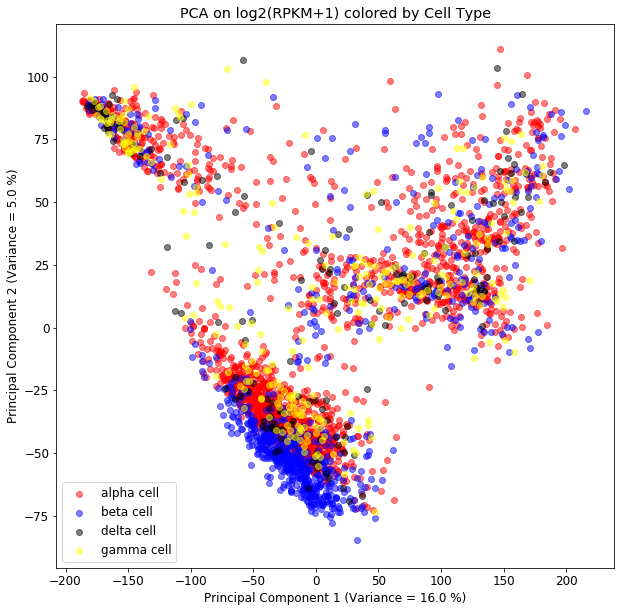

In [29]:
plot_2D_phenotype(components=princ_comp_unfiltered_log_rpkm, 
                   option='cell_type',
                   phenotypes=merged_pheno['cell_type'].values, 
                   phenotype_dict=cell_type_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1) colored by Cell Type')

## PCA results, colored by disease condition

In [30]:
dis_cond_dict = {'normal': 0 , 'type II diabetes mellitus' : 1}

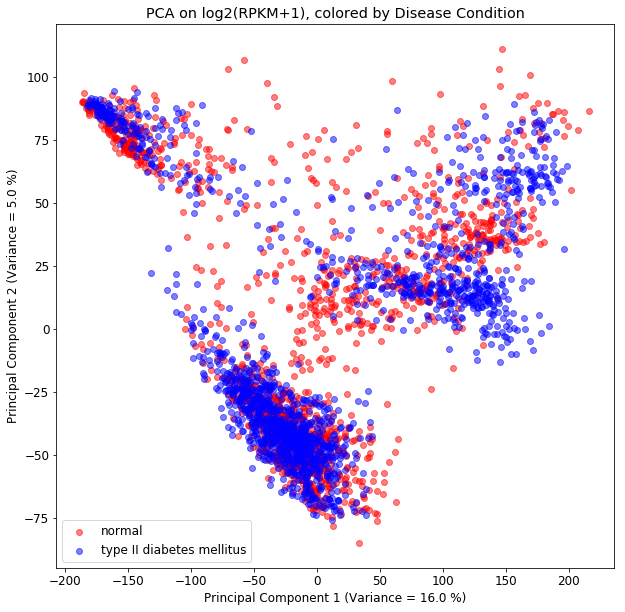

In [31]:
plot_2D_phenotype(components=princ_comp_unfiltered_log_rpkm, 
                   option='disease_condition',
                   phenotypes=merged_pheno['disease_condition'].values, 
                   phenotype_dict=dis_cond_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1), colored by Disease Condition')

In [32]:
np.max(merged_mat_log.values)

20.693067057163056

In [33]:
np.min(merged_mat_log.values)

0.0

# ----Filtering genes and cells based on $log_{2}$RPKM----    
Keeping genes expressed in more than 500 cells at log 2 (RPKM+1) > 1

In [34]:
gene_counts = {} # values are number of cells with log2RPKM+1 > 1
for k in merged_mat_log.keys():
    arr = ((merged_mat_log[k] > 1).values == True)
    gene_counts[k] = np.count_nonzero(arr)

In [35]:
a = list(gene_counts.values())

In [36]:
np.max(a)

3064

In [37]:
np.min(a)

0

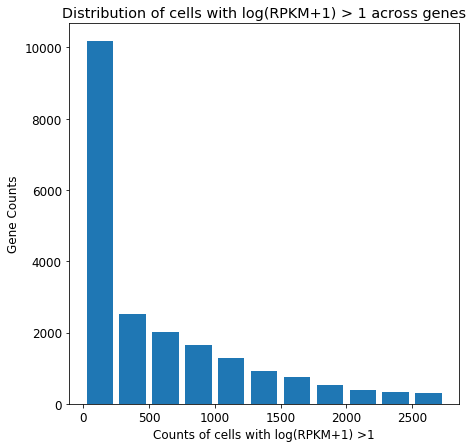

In [38]:
# Plotting distribution of number of cells with log >1 per gene
plot_histogram(values=a,
               bins=np.arange(0, 3000,250) ,
               title='Distribution of cells with log(RPKM+1) > 1 across genes',
               xlabel='Counts of cells with log(RPKM+1) >1',
               ylabel='Gene Counts')

In [39]:
above_500_cells_genes = []
for k, v in gene_counts.items():
    if v > 500:
        above_500_cells_genes.append(k)

In [40]:
len(above_500_cells_genes)

8256

Keeping cells with more than 1000 genes detected log 2 (RPKM+1) > 1

In [41]:
cell_counts = {} # values are number of genes with log2RPKM > 1
for cell in merged_mat_log.index:
    arr = ((merged_mat_log.loc[cell] > 1).values == True)
    cell_counts[cell] = np.count_nonzero(arr)

In [42]:
b = list(cell_counts.values())

In [43]:
print(np.max(b))
print(np.min(b))

10000
37


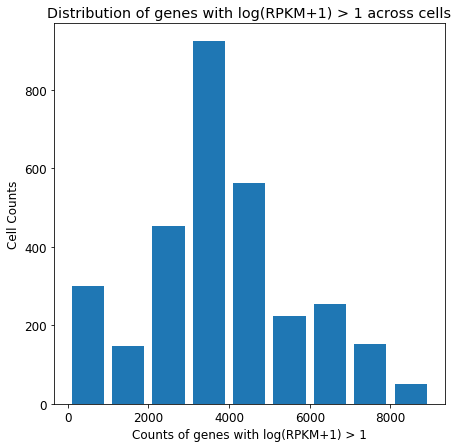

In [44]:
plot_histogram(values=b,
               bins=np.arange(0,10000, 1000),
               title='Distribution of genes with log(RPKM+1) > 1 across cells',
               xlabel='Counts of genes with log(RPKM+1) > 1',
               ylabel='Cell Counts')

In [45]:
above_1000_genes_cells = []
for k, v in cell_counts.items():
    if v > 1000:
        above_1000_genes_cells.append(k)

In [46]:
len(above_1000_genes_cells)

2766

In [47]:
# Filtering out only genes that do not satisfy criteria
merged_mat_log_filtered = full_dataset[above_500_cells_genes]

In [48]:
merged_mat_log_filtered.shape

(3067, 8256)

In [49]:
merged_mat_log_filtered.head(2)

,TRIB1,DDX39A,KIAA1107,RAB8A,DNAJB14,SMURF1,KANSL3,RBM17,TAOK3,CEP164,...,TTC14,COX7A2L,SMAD2,GRB2,PUM2,ZZEF1,MLLT6,LAMTOR2,ZNF362,PAFAH2
Sample_1329,0.000000,0.0,0.0,1.755956,0.00000,5.629304,2.409418,0.0,3.870493,2.806015,...,0.000000,7.476401,2.544634,3.241733,3.00716,0.0,0.0,0.0,2.343834,2.042469
Sample_1339,5.805096,0.0,0.0,0.488104,3.61524,3.650627,4.026003,0.0,1.905774,1.713036,...,0.818442,3.482977,1.467697,5.025414,0.85822,0.0,0.0,0.0,0.000000,0.000000


In [50]:
# Appending phenotypes of filtered rows:
filtered_pheno = merged_pheno[['cell_type', 'disease_condition', 'dataset']].loc[merged_mat_log_filtered.index]

In [51]:
filtered_pheno.shape

(3067, 3)

In [52]:
full_filtered_dataset = pd.concat([merged_mat_log_filtered, filtered_pheno], axis=1)
full_filtered_dataset.shape

(3067, 8259)

In [53]:
full_filtered_dataset.to_pickle('gans_input_data/2_merged_filtered_logRPKM_dataset.pkl')

In [54]:
merged_mat_log_filtered.to_pickle('gans_input_data/2_merged_filtered_logRPKM_dataset_without_pheno.pkl')

## PCA on filtered dataset

In [55]:
princ_comp_filtered_log_rpkm, var_ratio = get_PCA_components(n_comp=2, arr=merged_mat_log_filtered.values)

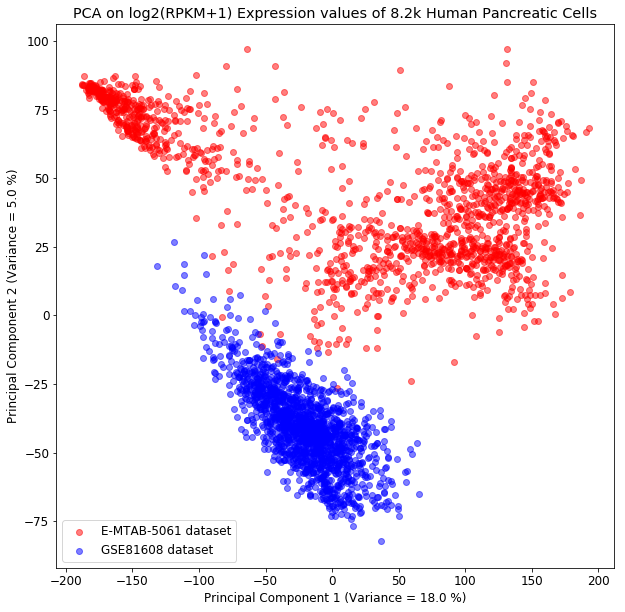

In [56]:
plot_2D_phenotype(components=princ_comp_filtered_log_rpkm,
                   option='dataset',
                   phenotypes=filtered_pheno['dataset'].values,
                   phenotype_dict=dataset_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1) Expression values of 8.2k Human Pancreatic Cells')

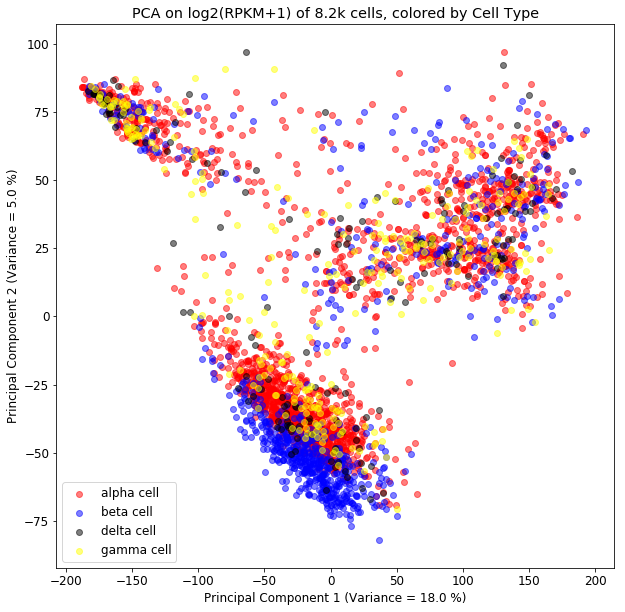

In [57]:
plot_2D_phenotype(components=princ_comp_filtered_log_rpkm,
                   option='cell_type',
                   phenotypes=filtered_pheno['cell_type'].values,
                   phenotype_dict=cell_type_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1) of 8.2k cells, colored by Cell Type')

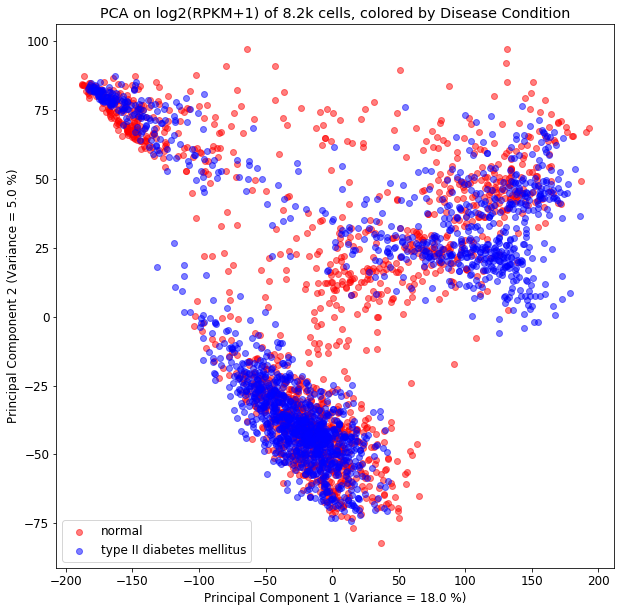

In [58]:
plot_2D_phenotype(components=princ_comp_filtered_log_rpkm,
                   option='disease_condition',
                   phenotypes=filtered_pheno['disease_condition'].values,
                   phenotype_dict=dis_cond_dict,
                   var_ratio=[round(i, 2) for i in var_ratio], 
                   title='PCA on log2(RPKM+1) of 8.2k cells, colored by Disease Condition')